# Lab 3 Exploration: Depth Images

In this notebook, we will learn how to use depth images from the racecar's camera to identify the distance at specific points and find the closest pixel.  We will also explore strategies for handling noise/measurement error.

Throughout this notebook, **<font style="color:red">text in bold red</font>** indicates a change you must make to the following code block before running it.


## Table of Contents
1. [Getting Started](#GettingStarted)
2. [Taking Depth Photos](#TakingDepthPhotos)
3. [Handling Noise](#HandlingNoise)
4. [Closest Point](#ClosestPoint)

<a id="GettingStarted"></a>
## 1. Getting Started

**<font style="color:red">If you are running the car in RacecarSim, set `isSimulation` to `True`</font>**. Leave `isSimulation` `False` if you are using a physical car.

In [1]:
# TODO: Update isSimulation if necessary
isSimulation = True

Next, we will import the necessary libraries for this notebook, including Python libraries (`cv`, `numpy`, etc.) and the Racecar library (`racecar_core`).

In [2]:
# Import Python libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import statistics
from nptyping import NDArray
from typing import Any, Tuple, List, Optional

# Import Racecar library
import sys
sys.path.append("../../library")
import racecar_core

The following functions will help us throughout this notebook.

In [3]:
def show_depth_image(
    depth_image: NDArray[(Any, Any), np.float32],
    max_depth: int = 400,
    points: List[Tuple[int, int]] = []
) -> None:
    """
    Displays a color image in the Jupyter Notebook.
    
    Args:
        depth_image: The image to display.
        max_depth: The farthest depth to show in the image in cm. Anything past this depth is shown as black.
        points: A list of points in (pixel row, pixel column) format to show on the image colored dots.
    """
    # Clip anything above max_depth
    np.clip(depth_image, None, max_depth, depth_image)

    # Shift down slightly so that 0 (no data) becomes the "farthest" color
    depth_image = (depth_image - 1) % max_depth

    # Convert depth values to colors
    color_image = cv.applyColorMap(-cv.convertScaleAbs(depth_image, alpha=255/max_depth), cv.COLORMAP_INFERNO)
    
    # Draw a dot at each point in points
    for point in points:
        cv.circle(color_image, (point[1], point[0]), 6, (0, 255, 0), -1)

    # Show the image with Matplotlib
    plt.imshow(cv.cvtColor(color_image, cv.COLOR_BGR2RGB))
    plt.show()


def add_noise(
    depth_image: NDArray[(Any, Any), np.float32],
    error_percent = 0.1,
    null_percent: float = 0.005
) -> NDArray[(Any, Any), np.float32]:
    """
    Adds noise to a depth image.
    
    Args:
        depth_image: The original image to which to add noise.
        error_percent: The error percentage to introduce to each measurement.
        null_percent: The percentage of pixels to set to zero.
    
    Returns:
        A copy of the provided depth_image with noise added.
    """
    # Copy the original image
    image = np.copy(depth_image) 
    
    # Apply error_percent to each measurement (gaussian error)
    gauss = np.random.normal(1, error_percent, image.shape)
    image *= gauss
    
    # Add null (zero) values
    num_nulls = int(image.size * null_percent)
    coords = [np.random.randint(0, i - 1, num_nulls) for i in image.shape]
    image[tuple(coords)] = 0.0
    
    return image


def crop(
    image: NDArray[(Any, ...), Any],
    top_left_inclusive: Tuple[float, float],
    bottom_right_exclusive: Tuple[float, float]
) -> NDArray[(Any, ...), Any]:
    """
    Crops an image to a rectangle based on the specified pixel points.

    Args:
        image: The color or depth image to crop.
        top_left_inclusive: The (row, column) of the top left pixel of the crop rectangle.
        bottom_right_exclusive: The (row, column) of the pixel one past the bottom right corner of the crop rectangle.

    Returns:
        A cropped version of the image.

    Note:
        The top_left_inclusive pixel is included in the crop rectangle, but the
        bottom_right_exclusive pixel is not.
        
        If bottom_right_exclusive exceeds the bottom or right edge of the image, the
        full image is included along that axis.
    """
    # Extract the minimum and maximum pixel rows and columns from the parameters
    r_min, c_min = top_left_inclusive
    r_max, c_max = bottom_right_exclusive

    # Shorten the array to the specified row and column ranges
    return image[r_min:r_max, c_min:c_max]

Finally, we will create a racecar object.  If this step fails, make sure that `isSimulation` has the correct value.

In [4]:
# Create Racecar
rc = racecar_core.create_racecar(isSimulation)

>> Racecar created with the following options:
    Simulation (-s): [True]
    Headless (-h): [False]
    Initialize with display (-d): [False]


<a id="TakingDepthPhotos"></a>
## 2. Taking Depth Photos
A depth photo is similar to a color photo, except that each pixel stores a distance value rather than color values. In Jupyter Notebook, we can take a depth photo with the car's camera using `rc.camera.get_depth_image_async()`.  Outside of Jupyter Notebook, we must use `rc.camera.get_depth_image()` instead.

In order to make sense of the result, we will use `show_depth_image` to convert the distance measurements into colors. For example, the closest measurements are shown as bright yellow, ranging to red to purple to black (out of range).

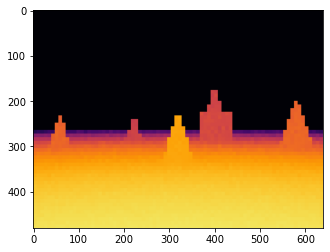

In [5]:
# Take a depth photo and show a colorized-version
image = rc.camera.get_depth_image_async()
show_depth_image(image)

Depth images are stored as two-dimensional numpy arrays, using a similar format to color images:

* **0th dimension**: pixel rows, indexed from top to bottom.
* **1st dimension**: pixel columns, indexed from left to right.

Let's inspect the distance at the center of the image. **<span style="color:red">Set `center_row` and `center_col` in the following code block to the center of the image.</span>**  You will likely wish to use `rc.camera.get_height()` and `rc.camera.get_width()`. 

In [24]:
# TODO: Calculate center row and column
center_row = rc.camera.get_height() // 2
center_col = rc.camera.get_width() // 2

# Print the distance of the center pixel
center_distance = image[center_row][center_col]
print(f"Distance at pixel {(center_row, center_col)}: {center_distance:.2f} cm")

Distance at pixel (240, 320): 151.88 cm


<a id="HandlingNoise"></a>
## 3. Handling Noise

As you saw in the previous section, we can calculate the distance of an object directly in front of the car by simply accessing the middle element of the depth image.  In practice, however, this approach is not reliable because all sensors have some amount of *noise*, a random variation in measured values.  Furthermore, some pixels may not receive any data, and thus have a *null value* of 0.0 cm.

To simulate this, the following code block randomly adds noise and null values to our image.

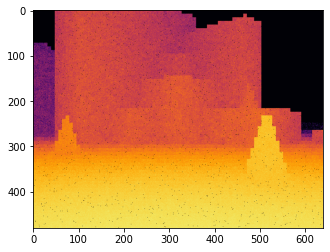

In [25]:
noisy_image = add_noise(image)
show_depth_image(noisy_image)

**Can you identify the noise and null values in this image?**

To see why this may be a problem, we will measure the center distance ten times with a new noisy version of our original image each time.

In [26]:
distances = []

# Randomize the image and calculate center distance 10 times
for i in range (1, 11):
    noisy_image = add_noise(image)
    center_distance = noisy_image[rc.camera.get_height() // 2][rc.camera.get_width() // 2]
    print(f"Center distance {i}: {center_distance:.2f} cm")
    distances.append(float(center_distance))

# Calculate the mean and standard deviation of the center distance measurement
print(f"\nMean: {statistics.mean(distances):.2f} cm")
print(f"Standard deviation: {statistics.stdev(distances):.2f} cm")

Center distance 1: 157.18 cm
Center distance 2: 182.47 cm
Center distance 3: 159.98 cm
Center distance 4: 155.55 cm
Center distance 5: 161.34 cm
Center distance 6: 159.07 cm
Center distance 7: 149.25 cm
Center distance 8: 147.82 cm
Center distance 9: 157.89 cm
Center distance 10: 147.86 cm

Mean: 157.84 cm
Standard deviation: 10.02 cm


**What is the standard deviation across these trials?** To put that in perspective, suppose that we wanted to use the center distance to estimate the speed of the car.  If the car was standing still but the center distance changed by 5 cm per frame, we would estimate that the car was traveling over 3 m/s, more than the top speed of the car!

With noise, a single pixel is not a reliable measurement of distance.  Instead, we should factor in neighboring pixels to mitigate the effect of error/noise. One way to do this is by applying a [Gaussian blur](https://en.wikipedia.org/wiki/Gaussian_blur) to the original image.  Each pixel is updated with a weighted average of its neighbors, with greater weight given to closer neighbors.  The *kernel size* determines how large of an area to include in this average.

In the following code block, we use the OpenCV function [GaussianBlur](https://docs.opencv.org/4.3.0/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1) to apply Gaussian blur to our depth image.

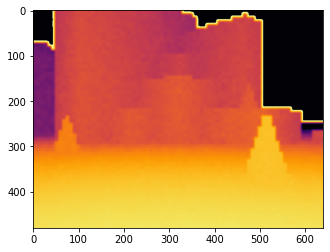

In [27]:
# Kernel size must be odd
kernel_size = 11
blurred_image = cv.GaussianBlur(image, (kernel_size, kernel_size), 0)
show_depth_image(blurred_image)

Aside: If your image contained areas that were out of range, you may notice a sharp outline appearing along the boundary of these regions.  This occurs because out of range pixels are represented as 0.0, so when averaged with surrounding areas, they cause the average to *decrease*.  This causes pixel near out-of-range regions to appear *closer* after blurring. 

Run the following code block and use the slider to experiment with different kernel sizes.  **As kernel size increases, does the image become more or less blurred? Why?**

In [29]:
def blur_image(depth_image, kernel_size):
    # Blur and show image
    blurred_image = cv.GaussianBlur(image, (kernel_size, kernel_size), 0)
    show_depth_image(blurred_image)
    
widgets.interact(blur_image, 
                 depth_image=widgets.fixed(image),
                 kernel_size=widgets.IntSlider(1, 1, 61, 2, continuous_update = False))

interactive(children=(IntSlider(value=1, continuous_update=False, description='kernel_size', max=61, min=1, st…

<function __main__.blur_image(depth_image, kernel_size)>

Each individual pixel in the blurred image is an average of many pixels from the original image.  This helps compensate for noise and null values.

You now have all of the tools necessary to write a more robust center distance algorithm.  **<span style="color:red">Finish writing `get_depth_image_center_distance` in the following code block.</span>**

In [30]:
def get_depth_image_center_distance(
    depth_image: NDArray[(Any, Any), np.float32], 
    kernel_size: int
) -> float:
    """
    Finds the distance of a pixel averaged with its neighbors in a depth image.

    Args:
        depth_image: The depth image to process.
        pix_coord: The (row, column) of the pixel to measure.
        kernel_size: The size of the area to average around the pixel.

    Returns:
        The distance in cm of the object at the provided pixel.

    Warning:
        kernel_size must be positive and odd.

    Note:
        The larger the kernel_size, the more that the requested pixel is averaged
        with the distances of the surrounding pixels.  This helps reduce noise at the
        cost of reduced accuracy.
    """
    # TODO: apply a gaussian blur to the image
    blurred_image = cv.GaussianBlur(depth_image, (kernel_size, kernel_size), 0)
    
    # TODO: find and return the center distance
    center_row = rc.camera.get_height() // 2
    center_col = rc.camera.get_width() // 2
    return blurred_image[center_row][center_col]

Let's repeat the same test as before using our `get_depth_image_center_distance` function.  Once again, we will randomly add noise to the original image and measure the center distance ten times.

In [31]:
kernel_size = 11
distances = []

# Randomize the image and calculate center distance 10 times
for i in range (1, 11):
    noisy_image = add_noise(image)
    center_distance = (noisy_image, kernel_size)
    print(f"Center distance {i}: {center_distance:.2f} cm")
    distances.append(float(center_distance))

# Calculate the mean and standard deviation of the center distance measurement
print(f"\nMean: {statistics.mean(distances):.2f} cm")
print(f"Standard deviation: {statistics.stdev(distances):.2f} cm")

Center distance 1: 147.61 cm
Center distance 2: 146.92 cm
Center distance 3: 150.79 cm
Center distance 4: 151.68 cm
Center distance 5: 153.24 cm
Center distance 6: 150.83 cm
Center distance 7: 148.88 cm
Center distance 8: 151.74 cm
Center distance 9: 150.64 cm
Center distance 10: 153.34 cm

Mean: 150.56 cm
Standard deviation: 2.17 cm


Compare these results to our original test without blurring.  **Has the standard deviation decreased?**

<a id="ClosestPoint"></a>
## 4. Closest Point

We can also use depth images to find the closest point, which is useful for identifying and reacting to nearby objects. Once again, we should apply a Gaussian blur to minimize the impact of noise.

However, a problem will arise if any part of the depth image is out of range, as it will have a depth value of 0.0.  To fix this, we can shift down each value by a small amount (such as 0.01 cm) and then mod by a large number (such as 10,000 cm).  This way, 0.0 becomes -0.01, which after modding becomes 9,999.99 cm, a very large distance that will not interfere with the true minimum.

**<span style="color:red">Finish writing `get_closest_pixel` to find the row and column of the closest pixel in a depth image.</span>**.  You will likely wish to use the OpenCV function [minMaxLoc](https://docs.opencv.org/4.3.0/d2/de8/group__core__array.html#gab473bf2eb6d14ff97e89b355dac20707).  Note that the positions returned by ``minMaxLoc`` are in (column, row) format, while `get_closest_pixel` should return in (row, column) format. 

In [59]:
def get_closest_pixel(
    depth_image: NDArray[(Any, Any), np.float32],
    kernel_size: int = 5
) -> Tuple[int, int]:
    """
    Finds the closest pixel in a depth image.

    Args:
        depth_image: The depth image to process.
        kernel_size: The size of the area to average around each pixel.

    Returns:
        The (row, column) of the pixel which is closest to the car.

    Warning:
        kernel_size be positive and odd.
        It is highly recommended that you crop off the bottom of the image, or else
        this function will likely return the ground directly in front of the car.

    Note:
        The larger the kernel_size, the more that the depth of each pixel is averaged
        with the distances of the surrounding pixels.  This helps reduce noise at the
        cost of reduced accuracy.
    """
    # Shift 0.0 values to 10,000 so they are not considered for the closest pixel
    depth_image = (depth_image - 0.01) % 10000
    
    # TODO: Apply a gaussian blur using kernel_size
    blurred_image = cv.GaussianBlur(depth_image, (kernel_size, kernel_size), 0)

    # TODO: Find the pixel location of the minimum depth and return it
    #mask = np.zeros(blurred_image.shape[:2],np.uint8)
    #mask[0:blurred_image.shape[0]*5//8,0:blurred_image.shape[1]] = 255
    #minVal, maxVal, minLoc, maxLoc = cv.minMaxLoc(blurred_image, mask)

    minVal, maxVal, minLoc, maxLoc = cv.minMaxLoc(blurred_image)
    return minLoc[1], minLoc[0]

Let's use `get_closest_pixel` to draw a green dot at the location of the closest pixel.

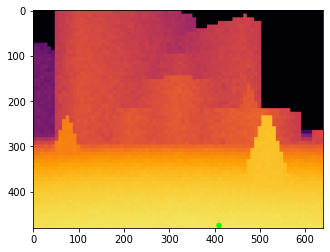

In [60]:
closest_pixel = get_closest_pixel(image)
show_depth_image(image, points=[closest_pixel])

Unless something is directly in front of the camera, the closest point was likely the ground in front of the car.  This is not a particularly useful result, so we should first crop off the bottom of the image.

Right now, `top_left_inclusive` and `bottom_right_exclusive` contain (row, column) pairs which include the entire image. **<span style="color:red">Update `top_left_inclusive` and `bottom_right_exclusive` to crop off the bottom third of the image before running `get_depth_image_center_distance`.</span>**

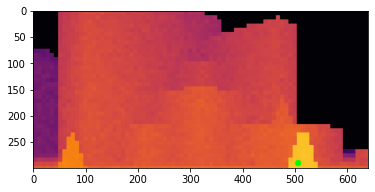

In [62]:
# TODO: Change top_left_inclusive and/or bottom_right_exclusive to crop off the bottom third of the image
top_left_inclusive = (0, 0)
bottom_right_exclusive = (rc.camera.get_height()*5//8, rc.camera.get_width())

cropped_image = crop(image, top_left_inclusive, bottom_right_exclusive)
closest_pixel = get_closest_pixel(cropped_image)
show_depth_image(cropped_image, points=[closest_pixel])

The image should now show a more meaningful closest point.  If necessary, you may need to experiment with different crop windows or move the car and take a new depth image.

You are now ready to begin using the depth camera to implement a "safety stop" feature in `lab3a.py`.  Good luck, and don't be afraid to ask questions!